In [1]:
import pandas as pd
import numpy as np

# Loading the Data

In [2]:
# Load the cleaned data
df = pd.read_csv('cleaned_genre_lyrics.csv')#.drop(columns=['Unnamed: 0'])
df.head(3)

,artist,title,lyrics,genre
0,dolly parton,9 to 5,tumble outta bed stumble kitchen pour cup ambi...,country
1,taylor swift,nothing new (taylor's version) [from the vault],tell young `` girls go fun '' hunt slay ones a...,country
2,maren morris,my church,’ cussed sunday ’ cheated ’ lied ’ fallen grac...,country


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2561 entries, 0 to 2560
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  2561 non-null   object
 1   title   2561 non-null   object
 2   lyrics  2561 non-null   object
 3   genre   2561 non-null   object
dtypes: object(4)
memory usage: 80.2+ KB


In [4]:
texts = df['lyrics']
df_labels = df['genre']

In [5]:
cat_labels = []
for genre in df_labels:
    if genre == "country": cat_labels.append(0)
    elif genre == "pop": cat_labels.append(1)
    elif genre == "r-b": cat_labels.append(2)
    elif genre == "rock": cat_labels.append(3)
    elif genre == "rap": cat_labels.append(4)

# Loading in Pre-trained Word Vectors (GLoVE)

In [6]:
def load_glove(file):
    
    f = open(file, 'r', encoding='utf8')
    glove_model = {}
    
    for line in f:
        split_lines = line.split()
        if len(split_lines) > 1:
            word = split_lines[0]
            word_embedding = np.array([float(value) for value in split_lines[1:]])
            
            glove_model[word] = word_embedding
    
    print(len(glove_model), " words loaded")
    return glove_model

In [7]:
glove_path = '../glove.6B.200d.txt'

glove_pretrained = load_glove(glove_path)

400000  words loaded


In [8]:
type(glove_pretrained)

dict

# Baseline Model \#1

In [9]:
import tensorflow as tf
from tensorflow import keras


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

### Creating our Vocabulary and Tokenizer

In [35]:
NUM_WORDS = 200
tokenizer = Tokenizer(num_words=NUM_WORDS, 
                      filters='’()``''')

# Create vocabulary from lyrics data
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

vocab_size = len(word_index)
vocab_size

28713

In [36]:
MAX_SEQUENCE_LENGTH = 100

# Creating our data matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Creating label matrix 
labels = tf.keras.utils.to_categorical(cat_labels)
labels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

### Creating Embedding Matrix from GLoVE embeddings

In [37]:
# Creating our embeddings matrix 

EMBEDDING_DIM = 200
embeddings_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = glove_pretrained.get(word)
    
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [38]:
[embeddings_matrix]

[array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.6356  , -0.061983,  0.68573 , ..., -0.1713  , -0.48949 ,
         -0.029627],
        [ 0.58852 ,  0.23437 ,  0.015102, ...,  0.056616, -0.037464,
          0.51246 ],
        ...,
        [ 0.27567 ,  0.60437 ,  0.17058 , ..., -0.11173 , -0.067429,
          0.26818 ],
        [ 0.28251 , -0.24092 , -0.43196 , ..., -0.11973 ,  0.36483 ,
          0.12194 ],
        [-0.55458 ,  0.1008  ,  0.20118 , ..., -0.1304  , -0.29817 ,
         -0.21016 ]])]

In [39]:
# Splitting the data into test and train sets 
np.random.seed(12)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data_for_split = data[indices]
labels_for_split = labels[indices]

In [40]:
VALIDATION_SPLIT = .20

nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]

x_val = data[-nb_validation_samples:]
y_val = data[-nb_validation_samples:]

In [41]:
x_train.shape, x_val.shape

((2049, 100), (512, 100))

In [42]:
labels_index = 5

### Creating the Model and its Layers

In [43]:
# Building the embeddings layers

from keras.layers import Embedding

embedding_layer = Embedding(vocab_size, 
                            EMBEDDING_DIM, 
                            weights=[embeddings_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, 
                            trainable=False, 
                            name="embedding_layer") # Might tweak this to be Truec

In [44]:
# Coding up the model 

from tensorflow.keras import layers

rnn_units = 200

sequence_input = layers.Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype="int32", name="input layer")

embeddings = embedding_layer(sequence_input)

rnn_output = layers.LSTM(rnn_units, name="LSTM")(embeddings)

output = layers.Dense(labels_index, activation="sigmoid", name="output_layer")(rnn_output)

In [45]:
model = keras.Model(inputs=sequence_input, outputs=output)

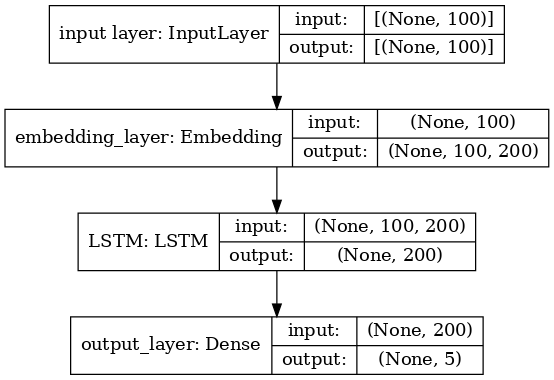

In [46]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [47]:
model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

early_stopping_callback = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                       min_delta=0, 
                                                       patience=3, 
                                                       verbose=1, 
                                                       mode="auto")

In [48]:
history = model.fit(x_train, y_train, 
                    epochs=5, batch_size=200, 
                    validation_split=.2, 
                    verbose = 1, 
                    callbacks=[early_stopping_callback])

Epoch 1/5
9/9 [==============================] - 4s 298ms/step - loss: 1.2939 - accuracy: 0.4381 - val_loss: 2.0402 - val_accuracy: 0.3268
Epoch 2/5
9/9 [==============================] - 2s 249ms/step - loss: 1.1773 - accuracy: 0.5345 - val_loss: 1.7123 - val_accuracy: 0.3195
Epoch 3/5
9/9 [==============================] - 2s 245ms/step - loss: 1.1005 - accuracy: 0.5827 - val_loss: 1.7961 - val_accuracy: 0.3024
Epoch 4/5
9/9 [==============================] - 2s 251ms/step - loss: 1.0574 - accuracy: 0.6083 - val_loss: 1.7147 - val_accuracy: 0.3463
Epoch 5/5
9/9 [==============================] - 2s 247ms/step - loss: 1.0488 - accuracy: 0.6089 - val_loss: 1.6855 - val_accuracy: 0.3024


# Baseline Model \#2

In [49]:
# Building the embeddings layers

from keras.layers import Embedding

embedding_layer = Embedding(vocab_size, 
                            EMBEDDING_DIM, 
                            weights=[embeddings_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, 
                            trainable=True, # Change from Model 1
                            name="embedding_layer") 

In [50]:
# Coding up the model 

rnn_units = 200

sequence_input = layers.Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype="int32", name="input layer")

embeddings = embedding_layer(sequence_input)

rnn_output = layers.LSTM(rnn_units, name="LSTM")(embeddings)

output = layers.Dense(labels_index, activation="sigmoid", name="output_layer")(rnn_output)

In [51]:
model = keras.Model(inputs=sequence_input, outputs=output)

In [52]:
model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

early_stopping_callback = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                       min_delta=0, 
                                                       patience=3, 
                                                       verbose=1, 
                                                       mode="auto")

In [53]:
history = model.fit(x_train, y_train, 
                    epochs=5, batch_size=200, 
                    validation_split=.2, 
                    verbose = 1, 
                    callbacks=[early_stopping_callback])

Epoch 1/5
9/9 [==============================] - 4s 323ms/step - loss: 1.3036 - accuracy: 0.4613 - val_loss: 1.9388 - val_accuracy: 0.1390
Epoch 2/5
9/9 [==============================] - 2s 276ms/step - loss: 1.1759 - accuracy: 0.5369 - val_loss: 1.7294 - val_accuracy: 0.3244
Epoch 3/5
9/9 [==============================] - 2s 273ms/step - loss: 1.1113 - accuracy: 0.5924 - val_loss: 1.8293 - val_accuracy: 0.2146
Epoch 4/5
9/9 [==============================] - 2s 275ms/step - loss: 1.0681 - accuracy: 0.5937 - val_loss: 1.7343 - val_accuracy: 0.3244
Epoch 5/5
9/9 [==============================] - 2s 273ms/step - loss: 1.0183 - accuracy: 0.6290 - val_loss: 1.7795 - val_accuracy: 0.2976
Epoch 00005: early stopping


# Baseline Model \#3

In [58]:
model = keras.models.Sequential()
model.add(Embedding(vocab_size, 
                    EMBEDDING_DIM, 
                    weights=[embeddings_matrix], 
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=True,
                    name="embedding_layer"))


model.add(layers.LSTM(rnn_units, activation='sigmoid', name="LSTM", return_sequences=True))
model.add(layers.Dropout(0.5))
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(labels_index, 
                       activation='softmax', 
                       name="output_layer"))


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [59]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                        min_delta=0, 
                                                        patience=3, 
                                                        verbose=1, 
                                                        mode="auto")

In [60]:
history = model.fit(x_train, y_train, 
                    epochs=5, batch_size=200, 
                    validation_split=.2, 
                    verbose = 1, 
                    callbacks=[early_stopping_callback])

Epoch 1/5
9/9 [==============================] - 5s 309ms/step - loss: 1.6736 - accuracy: 0.3374 - val_loss: 1.7515 - val_accuracy: 0.2098
Epoch 2/5
9/9 [==============================] - 3s 284ms/step - loss: 1.3309 - accuracy: 0.5790 - val_loss: 1.3894 - val_accuracy: 0.3659
Epoch 3/5
9/9 [==============================] - 3s 279ms/step - loss: 1.2094 - accuracy: 0.6126 - val_loss: 1.5825 - val_accuracy: 0.3171
Epoch 4/5
9/9 [==============================] - 3s 279ms/step - loss: 1.0983 - accuracy: 0.6394 - val_loss: 1.5635 - val_accuracy: 0.3390
Epoch 5/5
9/9 [==============================] - 3s 282ms/step - loss: 1.0650 - accuracy: 0.6370 - val_loss: 1.5990 - val_accuracy: 0.3146
Epoch 00005: early stopping


In [61]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 100, 200)          5742600   
_________________________________________________________________
LSTM (LSTM)                  (None, 100, 200)          320800    
_________________________________________________________________
dropout (Dropout)            (None, 100, 200)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 1005      
Total params: 6,064,405
Trainable params: 6,064,405
Non-trainable params: 0
_________________________________________________________________
None
